### Import relevant packages 

In [52]:
import numpy as np

### NPV Buy and NPV Rent

In [53]:
def annuitaet_zahlung(kreditsumme: float, zins: float, tilgung: float) -> float:

    if kreditsumme <= 0:
        return 0.0
    if zins < 0 or tilgung < 0:
        raise ValueError("Zins und Tilgung müssen > 0 sein")

    return kreditsumme * (zins + tilgung)

def buy_outflows_und_eigenkapital(kaufpreis_pro_m2: float, zins: float, tilgung: float, betrachtungszeitraum: int, 
                                  wohnflaeche_m2: float = 80.0, eigenkapitalquote: float = 0.20, kaufnebenkosten_quote: float = 0.10, 
                                  instandhaltung_quote: float = 0.01, preissteigerung_immobilie: float = 0.02,):
    
    H = int(betrachtungszeitraum)
    if H <= 0:
        return np.nan, np.array([])

    kaufpreis = kaufpreis_pro_m2 * wohnflaeche_m2
    kaufnebenkosten = kaufnebenkosten_quote * kaufpreis
    eigenkapital = eigenkapitalquote * kaufpreis + kaufnebenkosten
    darlehen = (1.0 - eigenkapitalquote) * kaufpreis

    annuitaet = annuitaet_zahlung(darlehen, zins, tilgung)
    restschuld = darlehen

    buy_outflow = np.zeros(H + 1)
    for t in range(1, H + 1):
        immowert_t = kaufpreis * (1.0 + preissteigerung_immobilie) ** t

        zinsen_t = restschuld * zins
        tilgung_t = max(0.0, annuitaet - zinsen_t)
        tilgung_t = min(tilgung_t, restschuld)
        restschuld = restschuld - tilgung_t

        instandhaltung_t = instandhaltung_quote * immowert_t
        buy_outflow[t] = (zinsen_t + tilgung_t + instandhaltung_t)

    return eigenkapital, buy_outflow

def npv_kaufen(kaufpreis_pro_m2: float, zins: float, erwartete_rendite: float, tilgung: float, betrachtungszeitraum: int = 10, 
               wohnflaeche_m2: float = 80.0, eigenkapitalquote: float = 0.20, kaufnebenkosten_quote: float = 0.10, 
               verkaufskosten_quote: float = 0.05, instandhaltung_quote: float = 0.01, preissteigerung_immobilie: float = 0.02,
               steuersatz_veraeusserungsgewinn: float = 0.25) -> float:
    
    H = int(betrachtungszeitraum)
    if H <= 0:
        return np.nan

    # Initialwerte
    kaufpreis = float(kaufpreis_pro_m2) * float(wohnflaeche_m2)
    kaufnebenkosten = kaufnebenkosten_quote * kaufpreis
    anschaffungskosten = kaufpreis + kaufnebenkosten
    eigenkapital = eigenkapitalquote * kaufpreis + kaufnebenkosten
    darlehen = (1.0 - eigenkapitalquote) * kaufpreis
    annuitaet = annuitaet_zahlung(darlehen, zins, tilgung)
    restschuld = darlehen

    # CF Betrachtung    
    cashflows = np.zeros(H + 1)
    # CF0
    cashflows[0] = -eigenkapital
    # CF1 bis CFH+1
    for t in range(1, H + 1):
        immowert_t = kaufpreis * (1.0 + preissteigerung_immobilie) ** t
        zinsen_t = restschuld * zins
        tilgung_t = max(0.0, annuitaet - zinsen_t)
        tilgung_t = min(tilgung_t, restschuld)
        restschuld = max(0.0, restschuld - tilgung_t)
        instandhaltung_t = instandhaltung_quote * immowert_t
        cashflows[t] = -(zinsen_t + tilgung_t) - instandhaltung_t

    # CFH: CF bei Verkauf
    immowert_H = kaufpreis * (1.0 + preissteigerung_immobilie) ** H
    verkaufserloes_netto = immowert_H * (1.0 - verkaufskosten_quote)
    veraeusserungsgewinn = verkaufserloes_netto - anschaffungskosten

    steuer = 0.0
    if H < 10:
        steuer = max(0.0, veraeusserungsgewinn) * steuersatz_veraeusserungsgewinn

    cashflows[H] += (verkaufserloes_netto - steuer - restschuld)

    # Discounting Cash Flows
    diskontfaktoren = np.array([(1.0 + erwartete_rendite) ** t for t in range(H + 1)])
    kapitalwert = float(np.sum(cashflows / diskontfaktoren))
    return kapitalwert

import numpy as np

def npv_mieten_und_investieren(
    mietpreis_pro_m2: float,
    rendite_invest: float,
    erwartete_rendite: float,
    betrachtungszeitraum: int = 10,
    wohnflaeche_m2: float = 80.0,
    mietsteigerung: float = 0.02,

    # Buy-Parameter (damit buy_outflow + Eigenkapital konsistent sind)
    kaufpreis_pro_m2: float = 0.0,
    zins: float = 0.0,
    tilgung: float = 0.0,
    eigenkapitalquote: float = 0.20,
    kaufnebenkosten_quote: float = 0.10,
    instandhaltung_quote: float = 0.01,
    preissteigerung_immobilie: float = 0.02,

    # Steuer auf Kapitalerträge (v0: Endbesteuerung auf Gewinn)
    kapitalertragssteuer_satz: float = 0.26375,  # 25% + Soli (ohne Kirchensteuer)
) -> float:
    """
    Kapitalwert (NPV) der Strategie "Mieten + Investieren" im Sinne deines Diagramms:

    - Start: Eigenkapital (inkl. Kaufnebenkosten) wird investiert.
    - Jährlich: Gesamtbudget entspricht den Buy-Kosten (buy_outflow = Bankrate+Instandhaltung).
      Davon wird Miete bezahlt; die Differenz (buy_outflow - Miete) wird (positiv/negativ) dem Portfolio zugeführt.
    - Terminal: Portfolio wird verkauft; Gewinne werden (v0) einmalig besteuert (Endbesteuerung).
    - NPV: Cashflows werden mit erwartete_rendite diskontiert.

    Voraussetzung: buy_outflows_und_eigenkapital(...) existiert und liefert (eigenkapital, buy_outflow[0..H]).
    """

    H = int(betrachtungszeitraum)
    if H <= 0:
        return np.nan

    # 1) Eigenkapital und Buy-Outflows als Referenz
    eigenkapital, buy_outflow = buy_outflows_und_eigenkapital(
        kaufpreis_pro_m2=kaufpreis_pro_m2,
        zins=zins,
        tilgung=tilgung,
        betrachtungszeitraum=H,
        wohnflaeche_m2=wohnflaeche_m2,
        eigenkapitalquote=eigenkapitalquote,
        kaufnebenkosten_quote=kaufnebenkosten_quote,
        instandhaltung_quote=instandhaltung_quote,
        preissteigerung_immobilie=preissteigerung_immobilie,
    )

    # 2) Jahresmiete t=1 (Basis)
    jahresmiete_0 = float(mietpreis_pro_m2) * float(wohnflaeche_m2) * 12.0

    # 3) Portfolio & Beitragskonto (für Endbesteuerung)
    vermoegen = float(eigenkapital)
    einzahlungen = float(eigenkapital)  # Summe positiver Einzahlungen (Cost Basis)

    # 4) Cashflows für NPV
    cashflows = np.zeros(H + 1)
    cashflows[0] = -float(eigenkapital)

    for t in range(1, H + 1):
        miete_t = jahresmiete_0 * (1.0 + mietsteigerung) ** (t - 1)

        # Geldanlage = Buy-Kosten - Miete (kann negativ sein => Entnahme)
        sparen_t = buy_outflow[t] - miete_t

        # Portfolio-Update
        vermoegen = vermoegen * (1.0 + float(rendite_invest)) + sparen_t

        # Cost basis nur bei echten Einzahlungen erhöhen
        if sparen_t > 0:
            einzahlungen += sparen_t

        # Dein Diagramm: Miete + Geldanlage = buy_outflow  => Gesamtoutflow = buy_outflow
        cashflows[t] = -buy_outflow[t]

    # 5) Terminal: Endbesteuerung auf Gewinne
    gewinn = max(0.0, vermoegen - einzahlungen)
    steuer = gewinn * float(kapitalertragssteuer_satz)
    vermoegen_netto = vermoegen - steuer

    cashflows[H] += vermoegen_netto

    # 6) Diskontieren
    diskontfaktoren = np.array([(1.0 + float(erwartete_rendite)) ** t for t in range(H + 1)])
    kapitalwert = float(np.sum(cashflows / diskontfaktoren))
    return kapitalwert


def npv_delta(kaufpreis_pro_m2: float, mietpreis_pro_m2: float, zins: float, tilgung: float, diskontsatz: float, rendite_invest: float,
    betrachtungszeitraum: int = 10, wohnflaeche_m2: float = 58.0, mietsteigerung: float = 0.02, kaufnebenkosten_quote: float = 0.10,
    eigenkapitalquote: float = 0.14, preissteigerung_immobilie: float = 0.03, instandhaltung_quote: float = 0.005,
    verkaufskosten_quote: float = 0.00, steuersatz_veraeusserungsgewinn: float = 0.25,) -> float:
   
    npv_buy = npv_kaufen(kaufpreis_pro_m2=kaufpreis_pro_m2, zins=zins, tilgung=tilgung, erwartete_rendite=diskontsatz, 
                         betrachtungszeitraum=betrachtungszeitraum, wohnflaeche_m2=wohnflaeche_m2, 
                         kaufnebenkosten_quote=kaufnebenkosten_quote, eigenkapitalquote=eigenkapitalquote,
                         preissteigerung_immobilie=preissteigerung_immobilie, instandhaltung_quote=instandhaltung_quote, 
                         verkaufskosten_quote=verkaufskosten_quote, steuersatz_veraeusserungsgewinn=steuersatz_veraeusserungsgewinn,)

    npv_rent_inv = npv_mieten_und_investieren(mietpreis_pro_m2=mietpreis_pro_m2, rendite_invest=rendite_invest, 
                                              erwartete_rendite=diskontsatz, betrachtungszeitraum=betrachtungszeitraum, 
                                              wohnflaeche_m2=wohnflaeche_m2, mietsteigerung=mietsteigerung, 
                                              kaufpreis_pro_m2=kaufpreis_pro_m2, zins=zins, tilgung=tilgung, 
                                              eigenkapitalquote=eigenkapitalquote, kaufnebenkosten_quote=kaufnebenkosten_quote, 
                                              instandhaltung_quote=instandhaltung_quote, 
                                              preissteigerung_immobilie=preissteigerung_immobilie,)

    return npv_buy - npv_rent_inv


,kaufpreis_pro_m2,mietpreis_pro_m2,zins,tilgung,diskontsatz,rendite_invest,wohnflaeche_m2,kaufnebenkosten_quote,eigenkapitalquote,preissteigerung_immobilie,instandhaltung_quote,verkaufskosten_quote,steuersatz_veraeusserungsgewinn,betrachtungszeitraum,delta_npv
4162,10942.808959,9.427459,0.040022,0.034810,0.022055,0.085455,118.309385,0.075965,0.215551,-0.009214,0.014529,0.006865,0.271390,10,-988063.112866
1387,11689.517044,11.109114,0.064238,0.022755,0.010028,0.058030,88.404299,0.112162,0.239197,-0.003411,0.014122,0.028268,0.263577,10,-902898.313695
4216,9471.643360,8.941845,0.065108,0.038246,0.027246,0.074058,113.370229,0.115154,0.090032,0.001744,0.008885,0.027604,0.267205,10,-815238.523488
4554,11215.690713,11.484452,0.057191,0.025893,0.013038,0.065175,88.321663,0.119454,0.277431,-0.000849,0.014894,0.015743,0.284863,10,-810452.226097
1527,10301.772130,16.152411,0.060197,0.015502,0.019998,0.070214,98.761041,0.114138,0.146139,-0.006075,0.009090,0.043767,0.298573,10,-755972.994203
2852,11035.581129,10.505638,0.059779,0.010633,0.039472,0.085124,116.543511,0.096183,0.270785,0.017293,0.011684,0.012285,0.251694,10,-754940.420387
2628,11958.517831,14.983730,0.058468,0.018316,0.011254,0.061540,75.744408,0.107200,0.051453,-0.005061,0.013316,0.024042,0.275319,10,-736928.221365
2495,10665.172638,6.021610,0.068696,0.011737,0.046619,0.083219,98.896130,0.069047,0.122797,-0.007117,0.004573,0.003051,0.252682,10,-724351.074920
1356,11518.477959,28.541303,0.041182,0.034773,0.018952,0.083025,119.962514,0.099908,0.118561,0.000111,0.014513,0.043568,0.287434,10,-723149.327609
3296,8987.389426,4.342511,0.039965,0.020926,0.012770,0.065229,113.944622,0.103965,0.077962,-0.006032,0.007140,0.011927,0.251379,10,-698788.434883


,kaufpreis_pro_m2,mietpreis_pro_m2,zins,tilgung,diskontsatz,rendite_invest,wohnflaeche_m2,kaufnebenkosten_quote,eigenkapitalquote,preissteigerung_immobilie,instandhaltung_quote,verkaufskosten_quote,steuersatz_veraeusserungsgewinn,betrachtungszeitraum,delta_npv
4934,4206.382851,34.863693,0.039713,0.029544,0.014906,0.047283,114.137022,0.094187,0.070025,0.049508,0.004277,0.030930,0.257587,10,490165.660440
2366,7179.060492,31.213149,0.019518,0.033136,0.021310,0.022283,90.237958,0.072878,0.371879,0.055339,0.004260,0.009736,0.260521,10,494331.970521
3210,2607.352226,34.155703,0.036331,0.029846,0.012116,0.043512,118.914111,0.117863,0.394453,0.047675,0.009006,0.028601,0.253743,10,502211.325675
2991,656.556176,33.011661,0.061097,0.023812,0.010270,0.060864,104.424760,0.077164,0.110457,0.053326,0.012215,0.022404,0.295251,10,504126.018579
4566,5813.129152,27.966443,0.018845,0.032321,0.011076,0.049274,100.406908,0.081997,0.086130,0.057974,0.006587,0.002111,0.270404,10,513217.076838
4605,11576.545750,34.377651,0.013184,0.017306,0.024728,0.085007,101.404982,0.067282,0.203431,0.055046,0.005475,0.027676,0.284462,10,520621.316195
1323,10926.878125,31.492076,0.009492,0.029623,0.017649,0.034762,108.457645,0.113711,0.078942,0.051175,0.011742,0.038786,0.289591,10,538830.133024
1532,915.966690,32.803877,0.007743,0.038156,0.013685,0.081081,105.663223,0.095665,0.062595,0.033480,0.010414,0.027860,0.281576,10,540691.067307
2664,10937.237434,29.817311,0.021414,0.034045,0.019567,0.021740,116.695251,0.105681,0.221158,0.049025,0.003910,0.036984,0.297816,10,575841.114136
3058,8295.734736,34.144138,0.007384,0.025790,0.036663,0.031429,105.844831,0.083683,0.197163,0.057337,0.005969,0.019273,0.288508,10,588890.564667


count      5000.000000
mean       4496.969272
std      180390.938258
min     -988063.112866
25%      -88426.464793
50%       23746.699178
75%      116817.130718
max      588890.564667
Name: delta_npv, dtype: float64


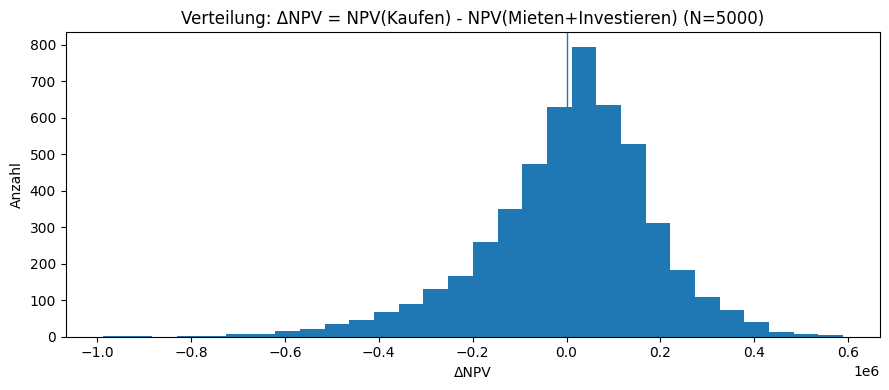

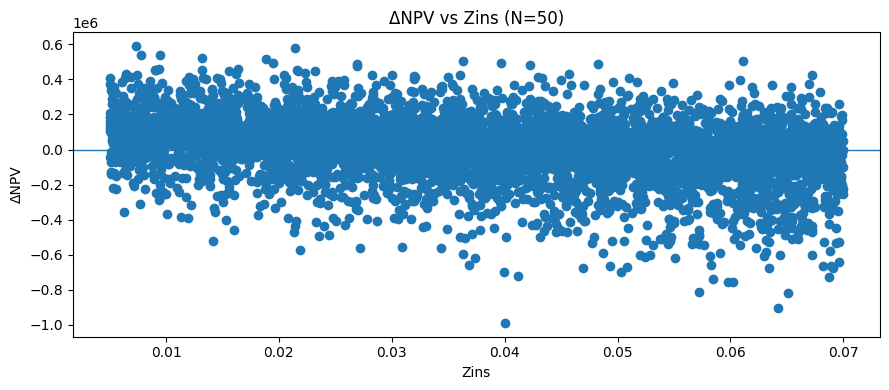

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

N = 5000
H = 10  # fix, kannst du auch zufällig machen

rows = []
for i in range(N):
    # --- zufällige Inputs (plausible Ranges, anpassbar)
    kaufpreis_pro_m2 = rng.uniforms(500, 12000)
    mietpreis_pro_m2 = rng.uniform(4, 35)

    zins = rng.uniform(0.005, 0.07)              # 0.5%–6%
    tilgung = rng.uniform(0.01, 0.04)           # 0.5%–4% anfängliche Tilgung

    diskontsatz = rng.uniform(0.01, 0.06)        # required return
    rendite_invest = rng.uniform(0.02, 0.09)     # Portfolio-Rendite

    wohnflaeche_m2 = rng.uniform(35, 120)

    kaufnebenkosten_quote = rng.uniform(0.06, 0.12)
    eigenkapitalquote = rng.uniform(0.05, 0.40)
    preissteigerung_immobilie = rng.uniform(-0.01, 0.06)
    instandhaltung_quote = rng.uniform(0.003, 0.015)
    verkaufskosten_quote = rng.uniform(0.00, 0.05)
    steuersatz_veraeusserungsgewinn = rng.uniform(0.25, 0.30)

    # --- ΔNPV berechnen
    try:
        delta = npv_delta(
            kaufpreis_pro_m2=kaufpreis_pro_m2,
            mietpreis_pro_m2=mietpreis_pro_m2,
            zins=zins,
            tilgung=tilgung,
            diskontsatz=diskontsatz,
            rendite_invest=rendite_invest,
            betrachtungszeitraum=H,
            wohnflaeche_m2=wohnflaeche_m2,
            mietsteigerung=0.02,
            kaufnebenkosten_quote=kaufnebenkosten_quote,
            eigenkapitalquote=eigenkapitalquote,
            preissteigerung_immobilie=preissteigerung_immobilie,
            instandhaltung_quote=instandhaltung_quote,
            verkaufskosten_quote=verkaufskosten_quote,
            steuersatz_veraeusserungsgewinn=steuersatz_veraeusserungsgewinn,
        )
    except Exception as e:
        delta = np.nan

    rows.append({
        "kaufpreis_pro_m2": kaufpreis_pro_m2,
        "mietpreis_pro_m2": mietpreis_pro_m2,
        "zins": zins,
        "tilgung": tilgung,
        "diskontsatz": diskontsatz,
        "rendite_invest": rendite_invest,
        "wohnflaeche_m2": wohnflaeche_m2,
        "kaufnebenkosten_quote": kaufnebenkosten_quote,
        "eigenkapitalquote": eigenkapitalquote,
        "preissteigerung_immobilie": preissteigerung_immobilie,
        "instandhaltung_quote": instandhaltung_quote,
        "verkaufskosten_quote": verkaufskosten_quote,
        "steuersatz_veraeusserungsgewinn": steuersatz_veraeusserungsgewinn,
        "betrachtungszeitraum": H,
        "delta_npv": delta,
    })

df_mc = pd.DataFrame(rows)

# 1) Einmal anschauen
display(df_mc.sort_values("delta_npv").head(10))
display(df_mc.sort_values("delta_npv").tail(10))

# 2) Summary
print(df_mc["delta_npv"].describe())

# 3) Histogramm
plt.figure(figsize=(9,4))
plt.hist(df_mc["delta_npv"].dropna(), bins=30)
plt.axvline(0, linewidth=1)
plt.title("Verteilung: ΔNPV = NPV(Kaufen) - NPV(Mieten+Investieren) (N=5000)")
plt.xlabel("ΔNPV")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

# 4) Optional: Scatter (was treibt ΔNPV?)
plt.figure(figsize=(9,4))
plt.scatter(df_mc["zins"], df_mc["delta_npv"])
plt.axhline(0, linewidth=1)
plt.title("ΔNPV vs Zins (N=50)")
plt.xlabel("Zins")
plt.ylabel("ΔNPV")
plt.tight_layout()
plt.show()
